## Spatio-Temporal Deep Learning for FacePad

<Shujaat Khan : shujaat123@gmail.com>

Step 1: Custom Data Loader with Augmentation

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
import random
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16, is_train=False):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['attack', 'real']
        self.samples = self._load_samples()
        self.num_frames = num_frames
        self.is_train = is_train  # Flag to check if the dataset is for training

    def _load_samples(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith('.mp4'):
                    samples.append((os.path.join(cls_dir, fname), self.classes.index(cls)))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_frames(video_path, self.num_frames)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Apply augmentation if training
        if self.is_train:
            angle = 0
            scale = 0
            if random.random() > 0.5:
                angle = random.uniform(-180, 180)  # Random rotation between -180 to 180 degrees
            if random.random() > 0.5:
                scale = random.uniform(0.7, 1.3)  # Random zoom between 70% to 130%
            frames = [self.apply_augmentation(frame, angle, scale) for frame in frames]
        
        frames = torch.stack(frames)
        return frames, label

    def _load_frames(self, video_path, num_frames):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Ensure the number of frames to load doesn't exceed the total number of frames in the video
        if self.is_train:
            start_frame = np.random.randint(0, max(1, total_frames - num_frames + 1))
        else:
            start_frame = 0
        
        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(F.to_tensor(frame))
        
        cap.release()
        
        # If there are not enough frames, repeat the last frame
        while len(frames) < num_frames:
            frames.append(frames[-1])
        
        return frames

    def apply_augmentation(self, image, angle, scale):
        """Apply random augmentations to the image for the training phase."""
        # if random.random() > 0.5:
        #     angle = random.uniform(-180, 180)  # Random rotation between -180 to 180 degrees
        if not(angle==0):
            image = F.rotate(image, angle)
        
        # if random.random() > 0.5:
        #     scale = random.uniform(0.9, 1.1)  # Random zoom between 90% to 110%
        if not(scale==0):
            image = F.affine(image, angle=0, translate=(0, 0), scale=scale, shear=0)
        
        return image

class AdaptiveCenterCropAndResize:
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): The desired output size after resizing (e.g., (32, 32)).
        """
        self.output_size = output_size
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        # Convert tensor to PIL image if necessary
        if isinstance(img, torch.Tensor):
            img = self.to_pil(img)

        # Get image size (width, height)
        width, height = img.size

        # Find the minimum dimension to create the largest possible square
        crop_size = min(width, height)

        # Calculate the coordinates to center-crop the square
        left = (width - crop_size) // 2
        top = (height - crop_size) // 2
        right = (width + crop_size) // 2
        bottom = (height + crop_size) // 2

        # Crop the image to the largest square
        img = img.crop((left, top, right, bottom))

        # Resize the cropped square to the desired output size
        img = img.resize(self.output_size, Image.Resampling.LANCZOS)

        # Convert the resized image back to a tensor
        img = self.to_tensor(img)

        return img

# Example usage
transform = transforms.Compose([
    AdaptiveCenterCropAndResize((224, 224)),  # Adaptive crop, resize, and convert to tensor
    transforms.ToPILImage(),
    transforms.ToTensor(), 
])

dataset_path = 'path-to/Datasets'
# Instantiate dataset with augmentation enabled for training
train_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/train', transform=transform, num_frames=3, is_train=True)
val_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/devel', transform=transform, num_frames=1, is_train=False)

def collate_fn(batch):
    max_length = max([frames.size(0) for frames, _ in batch])
    padded_frames = []
    labels = []
    for frames, label in batch:
        if frames.size(0) < max_length:
            padding = torch.zeros((max_length - frames.size(0), frames.size(1), frames.size(2), frames.size(3)))
            padded_frames.append(torch.cat((frames, padding), dim=0))
        else:
            padded_frames.append(frames)
        labels.append(label)
    
    padded_frames = torch.stack(padded_frames)
    labels = torch.tensor(labels)
    return padded_frames, labels

# Instantiate dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, pin_memory=True)


Step 2: Model Definition

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNTemporalAvgPooling(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNTemporalAvgPooling, self).__init__()
        # Use MobileNetV3 as the CNN backbone
        self.cnn = models.mobilenet_v3_large(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove the classifier to use the feature extractor

        # Adjust the final fully connected layer to match MobileNetV3's feature size (960 instead of 1280)
        self.fc = nn.Linear(960, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()  # Expect input as [batch_size, seq_len, channels, height, width]
        out_decision_t = []
        cnn_features = []
        
        for t in range(seq_len):
            # with torch.no_grad():
            feature = self.cnn(x[:, t, :, :, :])  # Extract CNN features for each frame
            cnn_features.append(feature)
         
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, 960]
        temporal_avg_features = cnn_features.mean(dim=1)  # Temporal average pooling: Shape: [batch_size, 960]

        # Pass through the final fully connected layer
        out = self.fc(temporal_avg_features)  # Shape: [batch_size, num_classes]
        return out

    def extract_intermediate_features(self, x):
        """Extract features before and after LSTM."""
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []
        for t in range(seq_len):
            # with torch.no_grad():
            feature = self.cnn(x[:, t, :, :, :])  # CNN output (before TAP)
            cnn_features.append(feature)
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_dim]
        temporal_avg_features = cnn_features.mean(dim=1)  # Temporal average pooling: Shape: [batch_size, 960]
        return cnn_features, temporal_avg_features
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = CNNTemporalAvgPooling(num_classes=2).to(device)

# # Example input (batch of videos with 16 frames of size 224x224)
example_input = torch.randn(4, 16, 3, 224, 224).to(device)

# Forward pass
output = model(example_input)
print(output.shape)  # Expected output shape: [batch_size, num_classes]


torch.Size([4, 2])


Step 3: Training Code with TensorBoard, Early Stopping, Checkpointing, and tqdm

In [3]:
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import os

# Hyperparameters and setup
criterion = nn.CrossEntropyLoss()  # For final classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir='logs')

# Directory to save checkpoints
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Function to save model checkpoints
def save_checkpoint(state, is_best, filename="checkpoint.pth"):
    torch.save(state, os.path.join(checkpoint_dir, filename))
    if is_best:
        torch.save(state, os.path.join(checkpoint_dir, "best_model.pth"))

# Training loop
def train_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(loader, unit="batch") as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Supervised Contrastive Learning (or CrossEntropy)
            loss = criterion(outputs, labels)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            tepoch.set_postfix(loss=running_loss/total, accuracy=100. * correct/total)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation loop
def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Initialize variables to track best validation loss
best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_patience = 10  # Number of epochs to wait before stopping early

# Example usage with the training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Train and validate for each epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    
    # Logging metrics
    writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save current checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
    }, is_best=False, filename=f"checkpoint_epoch_{epoch + 1}.pth")

    # Save best model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, is_best=True, filename=f"best_model_epoch_{epoch + 1}.pth")
        early_stopping_counter = 0  # Reset early stopping counter
    else:
        early_stopping_counter += 1

    # Early stopping condition
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

writer.close()


Epoch 0: 100%|██████████| 88/88 [02:02<00:00,  1.40s/batch, accuracy=86.6, loss=0.331]


Epoch 1/100, Train Loss: 0.3309, Val Loss: 0.1415, Val Acc: 94.57%


Epoch 1: 100%|██████████| 88/88 [02:26<00:00,  1.67s/batch, accuracy=95.6, loss=0.13] 


Epoch 2/100, Train Loss: 0.1298, Val Loss: 0.0674, Val Acc: 98.29%


Epoch 2: 100%|██████████| 88/88 [02:32<00:00,  1.74s/batch, accuracy=97, loss=0.0913]  


Epoch 3/100, Train Loss: 0.0913, Val Loss: 0.0485, Val Acc: 98.00%


Epoch 3: 100%|██████████| 88/88 [03:10<00:00,  2.16s/batch, accuracy=97.6, loss=0.0694]


Epoch 4/100, Train Loss: 0.0694, Val Loss: 0.0351, Val Acc: 99.14%


Epoch 4: 100%|██████████| 88/88 [03:17<00:00,  2.24s/batch, accuracy=98.8, loss=0.0463]


Epoch 5/100, Train Loss: 0.0463, Val Loss: 0.0270, Val Acc: 99.71%


Epoch 5: 100%|██████████| 88/88 [02:32<00:00,  1.73s/batch, accuracy=98.6, loss=0.042] 


Epoch 6/100, Train Loss: 0.0420, Val Loss: 0.0474, Val Acc: 98.00%


Epoch 6: 100%|██████████| 88/88 [01:57<00:00,  1.34s/batch, accuracy=98.3, loss=0.041] 


Epoch 7/100, Train Loss: 0.0410, Val Loss: 0.0475, Val Acc: 98.29%


Epoch 7: 100%|██████████| 88/88 [01:58<00:00,  1.34s/batch, accuracy=99.1, loss=0.0373]


Epoch 8/100, Train Loss: 0.0373, Val Loss: 0.0343, Val Acc: 99.14%


Epoch 8: 100%|██████████| 88/88 [02:03<00:00,  1.40s/batch, accuracy=99.1, loss=0.0292]


Epoch 9/100, Train Loss: 0.0292, Val Loss: 0.0509, Val Acc: 98.00%


Epoch 9: 100%|██████████| 88/88 [02:35<00:00,  1.76s/batch, accuracy=98.9, loss=0.0346]


Epoch 10/100, Train Loss: 0.0346, Val Loss: 0.0189, Val Acc: 99.43%


Epoch 10: 100%|██████████| 88/88 [02:02<00:00,  1.39s/batch, accuracy=99.1, loss=0.0303]


Epoch 11/100, Train Loss: 0.0303, Val Loss: 0.0432, Val Acc: 98.57%


Epoch 11: 100%|██████████| 88/88 [02:02<00:00,  1.39s/batch, accuracy=99.5, loss=0.0153]


Epoch 12/100, Train Loss: 0.0153, Val Loss: 0.0412, Val Acc: 98.57%


Epoch 12: 100%|██████████| 88/88 [02:25<00:00,  1.65s/batch, accuracy=99.4, loss=0.0238]


Epoch 13/100, Train Loss: 0.0238, Val Loss: 0.0197, Val Acc: 99.43%


Epoch 13: 100%|██████████| 88/88 [04:20<00:00,  2.96s/batch, accuracy=99.4, loss=0.0157] 


Epoch 14/100, Train Loss: 0.0157, Val Loss: 0.0148, Val Acc: 99.43%


Epoch 14: 100%|██████████| 88/88 [02:01<00:00,  1.39s/batch, accuracy=99.5, loss=0.0168]


Epoch 15/100, Train Loss: 0.0168, Val Loss: 0.0227, Val Acc: 99.14%


Epoch 15: 100%|██████████| 88/88 [02:11<00:00,  1.49s/batch, accuracy=99.4, loss=0.0189] 


Epoch 16/100, Train Loss: 0.0189, Val Loss: 0.0208, Val Acc: 98.86%


Epoch 16: 100%|██████████| 88/88 [01:56<00:00,  1.33s/batch, accuracy=99.3, loss=0.0256]


Epoch 17/100, Train Loss: 0.0256, Val Loss: 0.0288, Val Acc: 99.14%


Epoch 17: 100%|██████████| 88/88 [03:55<00:00,  2.67s/batch, accuracy=99.6, loss=0.0157]


Epoch 18/100, Train Loss: 0.0157, Val Loss: 0.0235, Val Acc: 98.86%


Epoch 18: 100%|██████████| 88/88 [05:15<00:00,  3.59s/batch, accuracy=99.4, loss=0.015]  


Epoch 19/100, Train Loss: 0.0150, Val Loss: 0.0119, Val Acc: 100.00%


Epoch 19: 100%|██████████| 88/88 [04:49<00:00,  3.29s/batch, accuracy=99.9, loss=0.00704]


Epoch 20/100, Train Loss: 0.0070, Val Loss: 0.0098, Val Acc: 100.00%


Epoch 20: 100%|██████████| 88/88 [01:58<00:00,  1.35s/batch, accuracy=99.6, loss=0.0105] 


Epoch 21/100, Train Loss: 0.0105, Val Loss: 0.0088, Val Acc: 99.71%


Epoch 21: 100%|██████████| 88/88 [02:00<00:00,  1.37s/batch, accuracy=99.4, loss=0.0133] 


Epoch 22/100, Train Loss: 0.0133, Val Loss: 0.0175, Val Acc: 100.00%


Epoch 22: 100%|██████████| 88/88 [03:42<00:00,  2.52s/batch, accuracy=99.2, loss=0.0216]


Epoch 23/100, Train Loss: 0.0216, Val Loss: 0.0160, Val Acc: 99.43%


Epoch 23: 100%|██████████| 88/88 [04:35<00:00,  3.13s/batch, accuracy=99.9, loss=0.0096] 


Epoch 24/100, Train Loss: 0.0096, Val Loss: 0.0216, Val Acc: 99.14%


Epoch 24: 100%|██████████| 88/88 [03:42<00:00,  2.53s/batch, accuracy=99.7, loss=0.00666]


Epoch 25/100, Train Loss: 0.0067, Val Loss: 0.0218, Val Acc: 98.86%


Epoch 25: 100%|██████████| 88/88 [02:29<00:00,  1.70s/batch, accuracy=99.8, loss=0.0074] 


Epoch 26/100, Train Loss: 0.0074, Val Loss: 0.0174, Val Acc: 99.71%


Epoch 26: 100%|██████████| 88/88 [02:15<00:00,  1.55s/batch, accuracy=99.9, loss=0.00557]


Epoch 27/100, Train Loss: 0.0056, Val Loss: 0.0146, Val Acc: 99.43%


Epoch 27: 100%|██████████| 88/88 [03:05<00:00,  2.10s/batch, accuracy=99.4, loss=0.0139] 


Epoch 28/100, Train Loss: 0.0139, Val Loss: 0.0201, Val Acc: 99.14%


Epoch 28: 100%|██████████| 88/88 [04:42<00:00,  3.21s/batch, accuracy=99.7, loss=0.00827]


Epoch 29/100, Train Loss: 0.0083, Val Loss: 0.0205, Val Acc: 98.86%


Epoch 29: 100%|██████████| 88/88 [05:33<00:00,  3.79s/batch, accuracy=99.6, loss=0.0149] 


Epoch 30/100, Train Loss: 0.0149, Val Loss: 0.0231, Val Acc: 99.14%


Epoch 30: 100%|██████████| 88/88 [02:13<00:00,  1.52s/batch, accuracy=99.7, loss=0.00896]


Epoch 31/100, Train Loss: 0.0090, Val Loss: 0.0398, Val Acc: 98.00%
Early stopping triggered


Step 4: Visualize a Random Sample and its Class Label

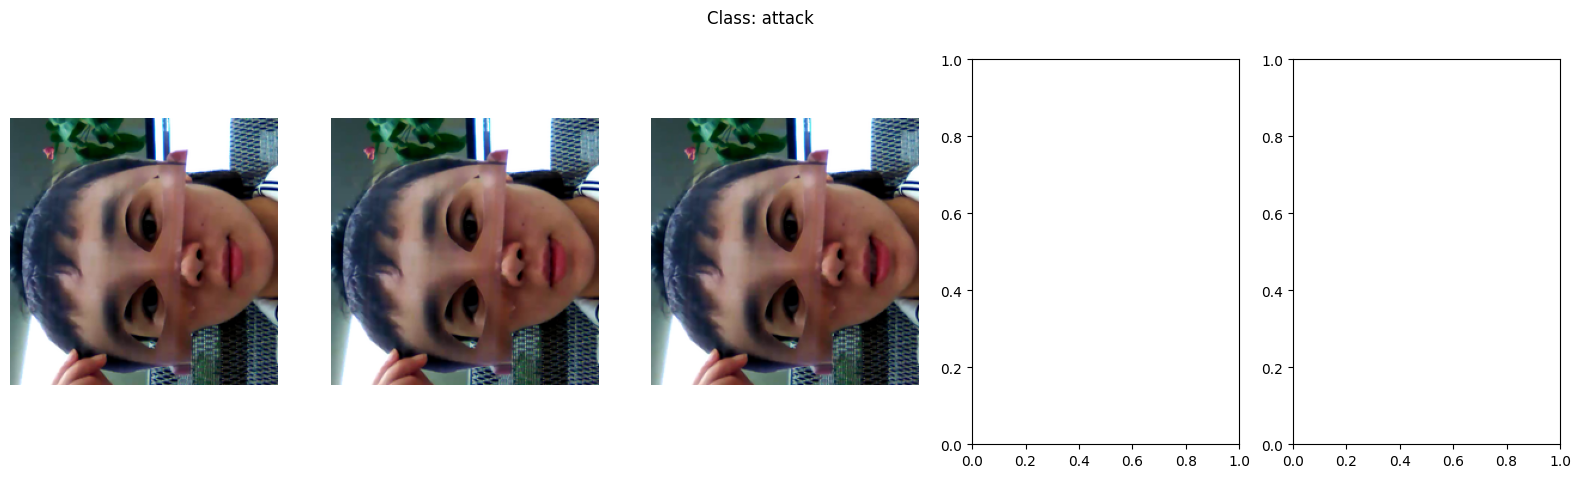

In [4]:
import matplotlib.pyplot as plt

def visualize_sample(dataset):
    idx = np.random.randint(len(dataset))
    frames, label = dataset[idx]
    frames = frames[0:5,:,:]
    class_name = dataset.classes[label]
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i, frame in enumerate(frames):
        axes[i].imshow(frame.permute(1, 2, 0))
        axes[i].axis('off')
    plt.suptitle(f"Class: {class_name}")
    plt.show()

# Visualize a random sample
visualize_sample(train_dataset)


Step 5: Evaluate on Test Dataset

In [5]:
import time
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc

def evaluate_all(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    all_times = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Start timing for prediction
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            all_times.append(inference_time)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            # For AUC, EER, etc.
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming class 1 is the target class
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics like AUC-ROC, EER, etc. based on collected labels and probabilities
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_roc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    # Calculate FAR, FRR, HTER, and Youden's Index
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    youdens_index = tpr[optimal_idx] - fpr[optimal_idx]
    far = fpr[optimal_idx]
    frr = fnr[optimal_idx]
    hter = (far + frr) / 2

    # Average inference time
    avg_inference_time = np.mean(all_times)

    # Test loss and accuracy
    test_loss = running_loss / len(loader.dataset)
    test_acc = 100. * correct / total

    # Return dictionary with all results
    return {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'auc_roc': auc_roc,
        'eer': eer,
        'hter': hter,
        'far': far,
        'frr': frr,
        'youdens_index': youdens_index,
        'optimal_threshold': optimal_threshold,
        'avg_inference_time': avg_inference_time,
        'fpr': fpr,
        'tpr': tpr,
        'labels': all_labels,
        'probs': all_probs
    }


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def generate_evaluation_summary(results):
    # Extract metrics from the results dictionary
    test_loss = results['test_loss']
    test_acc = results['test_acc']
    auc_roc = results['auc_roc']
    eer = results['eer']
    hter = results['hter']
    far = results['far']
    frr = results['frr']
    youdens_index = results['youdens_index']
    optimal_threshold = results['optimal_threshold']
    avg_inference_time = results['avg_inference_time']

    # Print summary
    print("\n--- Evaluation Summary ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}")
    print(f"Half Total Error Rate (HTER): {hter:.4f}")
    print(f"False Acceptance Rate (FAR): {far:.4f}")
    print(f"False Rejection Rate (FRR): {frr:.4f}")
    print(f"Youden's Index (Max): {youdens_index:.4f}")
    print(f"Optimal Threshold (Youden's Index): {optimal_threshold:.4f}")
    print(f"Average inference time per sample: {avg_inference_time:.6f} seconds")

    # Plot AUC-ROC Curve
    plot_roc_curve(results)

def plot_roc_curve(results):
    """Generate ROC curve from the evaluation results."""
    fpr = results['fpr']
    tpr = results['tpr']
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {results["auc_roc"]:.4f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_error_histogram(far, frr, eer):
    """Plot histograms of FAR, FRR, and EER values."""
    plt.figure(figsize=(10, 6))

    # Plot FAR
    plt.subplot(1, 3, 1)
    plt.bar(['FAR'], [far], color='red')
    plt.ylabel('Rate')
    plt.title('False Acceptance Rate (FAR)')

    # Plot FRR
    plt.subplot(1, 3, 2)
    plt.bar(['FRR'], [frr], color='blue')
    plt.ylabel('Rate')
    plt.title('False Rejection Rate (FRR)')

    # Plot EER
    plt.subplot(1, 3, 3)
    plt.bar(['EER'], [eer], color='green')
    plt.ylabel('Rate')
    plt.title('Equal Error Rate (EER)')

    plt.tight_layout()
    plt.show()

def plot_inference_time(avg_inference_time):
    """Plot inference time as a bar chart."""
    plt.figure(figsize=(6, 4))
    plt.bar(['Average Inference Time'], [avg_inference_time], color='purple')
    plt.ylabel('Time (seconds)')
    plt.title('Average Inference Time per Sample')
    plt.show()




--- Evaluation Summary ---
Test Loss: 0.0488
Test Accuracy: 98.46%
AUC-ROC: 0.9988
Equal Error Rate (EER): 0.0139
Half Total Error Rate (HTER): 0.0136
False Acceptance Rate (FAR): 0.0139
False Rejection Rate (FRR): 0.0134
Youden's Index (Max): 0.9728
Optimal Threshold (Youden's Index): 0.0443
Average inference time per sample: 0.110829 seconds


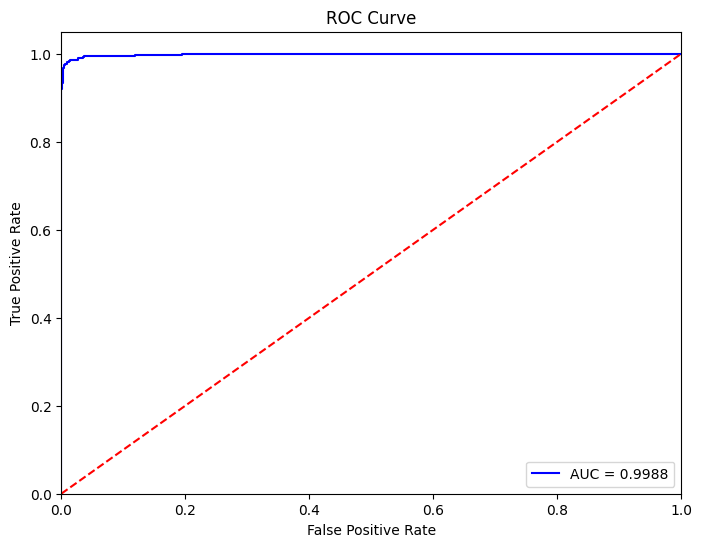

In [7]:
test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=5)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# checkpoint = torch.load('current_model.pth', weights_only=True)
checkpoint = torch.load('checkpoints/best_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# Assuming `evaluate` returns the results dictionary
results = evaluate_all(model, test_loader, criterion)

# Generate the summary and plot graphs
generate_evaluation_summary(results)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
criterion = nn.CrossEntropyLoss()

def generate_stats_vs_num_frames(model, root_dir, transform, criterion, batch_size=16, num_frames_range=(1, 55)):
    num_frames_list = list(range(num_frames_range[0], num_frames_range[1] + 1,5))
    
    # Containers to store results
    accuracy_list = []
    loss_list = []
    auc_roc_list = []
    eer_list = []
    hter_list = []
    inference_time_list = []
    
    # Loop through different number of frames
    for num_frames in num_frames_list:
        print(f"Evaluating with {num_frames} frames...")
        
        # Update the dataset and dataloader for current num_frames
        test_dataset = VideoDataset(root_dir=root_dir, transform=transform, num_frames=num_frames)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)
        
        # Evaluate the model and get the results
        results = evaluate_all(model, test_loader, criterion)
        
        # Store the stats
        accuracy_list.append(results['test_acc'])
        loss_list.append(results['test_loss'])
        auc_roc_list.append(results['auc_roc'])
        eer_list.append(results['eer'])
        hter_list.append(results['hter'])  # Assuming 'hter' is computed in the evaluate_all function
        inference_time_list.append(results['avg_inference_time'])
    
    # Plot the results, including HTER
    plot_stats_vs_num_frames(num_frames_list, accuracy_list, loss_list, auc_roc_list, eer_list, hter_list, inference_time_list)

def plot_stats_vs_num_frames(num_frames_list, accuracy_list, loss_list, auc_roc_list, eer_list, hter_list, inference_time_list):
    plt.figure(figsize=(12, 8))

    # Plot accuracy vs num_frames
    plt.subplot(2, 3, 1)
    plt.plot(num_frames_list, accuracy_list, marker='o', color='b')
    plt.xlabel('Number of Frames')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Number of Frames')

    # Plot loss vs num_frames
    plt.subplot(2, 3, 2)
    plt.plot(num_frames_list, loss_list, marker='o', color='r')
    plt.xlabel('Number of Frames')
    plt.ylabel('Loss')
    plt.title('Loss vs Number of Frames')

    # Plot AUC-ROC vs num_frames
    plt.subplot(2, 3, 3)
    plt.plot(num_frames_list, auc_roc_list, marker='o', color='g')
    plt.xlabel('Number of Frames')
    plt.ylabel('AUC-ROC')
    plt.title('AUC-ROC vs Number of Frames')

    # Plot EER vs num_frames
    plt.subplot(2, 3, 4)
    plt.plot(num_frames_list, eer_list, marker='o', color='c')
    plt.xlabel('Number of Frames')
    plt.ylabel('Equal Error Rate (EER)')
    plt.title('EER vs Number of Frames')

    # Plot HTER vs num_frames
    plt.subplot(2, 3, 5)
    plt.plot(num_frames_list, hter_list, marker='o', color='y')
    plt.xlabel('Number of Frames')
    plt.ylabel('Half Total Error Rate (HTER)')
    plt.title('HTER vs Number of Frames')

    # Plot inference time vs num_frames
    plt.subplot(2, 3, 6)
    plt.plot(num_frames_list, inference_time_list, marker='o', color='m')
    plt.xlabel('Number of Frames')
    plt.ylabel('Inference Time (seconds)')
    plt.title('Inference Time vs Number of Frames')

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()

# Example usage:
generate_stats_vs_num_frames(model, dataset_path+'/Rose_Youtu/test', transform, criterion)


In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def extract_intermediate_features(self, x):
        """Extract features before and after LSTM."""
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []
        for t in range(seq_len):
            with torch.no_grad():
                feature = self.cnn(x[:, t, :, :, :])  # CNN output (before LSTM)
            cnn_features.append(feature)
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_dim]
        lstm_out, _ = self.lstm(cnn_features)  # LSTM output
        lstm_out_last = lstm_out[:, -1, :]  # Take the output of the last LSTM cell
        return cnn_features, lstm_out_last

def extract_features(model, loader):
    """Extract features before and after the LSTM layer."""
    model.eval()
    features_before_lstm = []
    features_after_lstm = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            
            # Extract features using the model
            before_lstm, after_lstm = model.extract_intermediate_features(inputs)
            
            # Move features to CPU for t-SNE processing
            features_before_lstm.append(before_lstm.cpu().view(before_lstm.size(0), -1))  # Flatten the CNN features
            features_after_lstm.append(after_lstm.cpu())
            labels_list.append(labels.cpu())

    # Stack features and labels
    features_before_lstm = torch.cat(features_before_lstm, dim=0)
    features_after_lstm = torch.cat(features_after_lstm, dim=0)
    labels_list = torch.cat(labels_list, dim=0)
    
    return features_before_lstm, features_after_lstm, labels_list


In [10]:
from sklearn.manifold import TSNE

def apply_tsne(features):
    """Apply t-SNE to reduce features to 2D."""
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    return reduced_features


In [11]:
import matplotlib.pyplot as plt

def plot_tsne(reduced_features, labels, title):
    """Plot t-SNE results."""
    plt.figure(figsize=(8, 6))
    
    for label in torch.unique(labels):
        idx = labels == label
        plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=f'Class {label.item()}', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.legend()
    plt.show()


C:\Users\TechTroniX\AppData\Local\Temp\ipykernel_25916\3020041184.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth', 

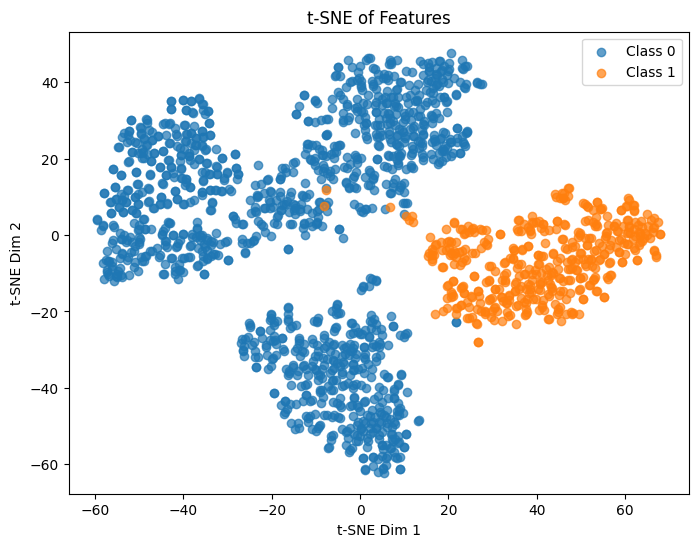

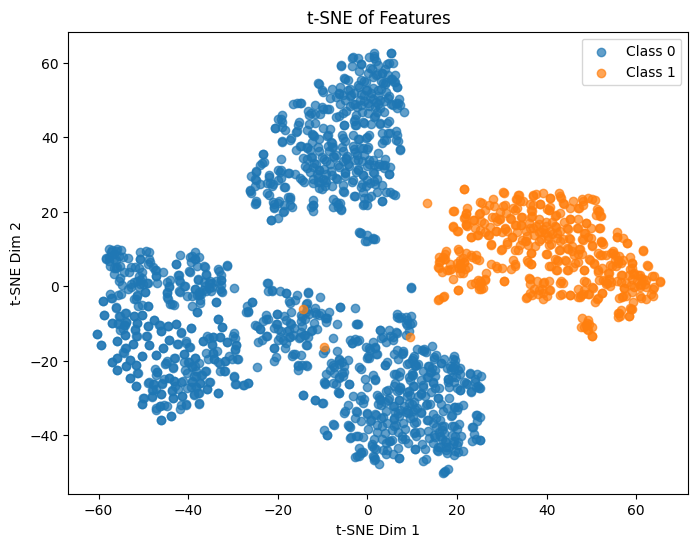

In [18]:
def visualize_tsne_before_after_lstm(model, loader):
    # Extract features before and after LSTM
    features_before_lstm, features_after_lstm, labels_list = extract_features(model, loader)
    
    # Apply t-SNE
    tsne_before_lstm = apply_tsne(features_before_lstm)

    # Plot the t-SNE results
    plot_tsne(tsne_before_lstm, labels_list, title="t-SNE of Features")

# Load the model weights, ignoring missing/unexpected keys
checkpoint = torch.load('checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=1)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# Visualize t-SNE before and after TAP
visualize_tsne_before_after_lstm(model, test_loader)

test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=10)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)


# Visualize t-SNE before and after TAP
visualize_tsne_before_after_lstm(model, test_loader)



torch.Size([1, 3, 3, 224, 224])


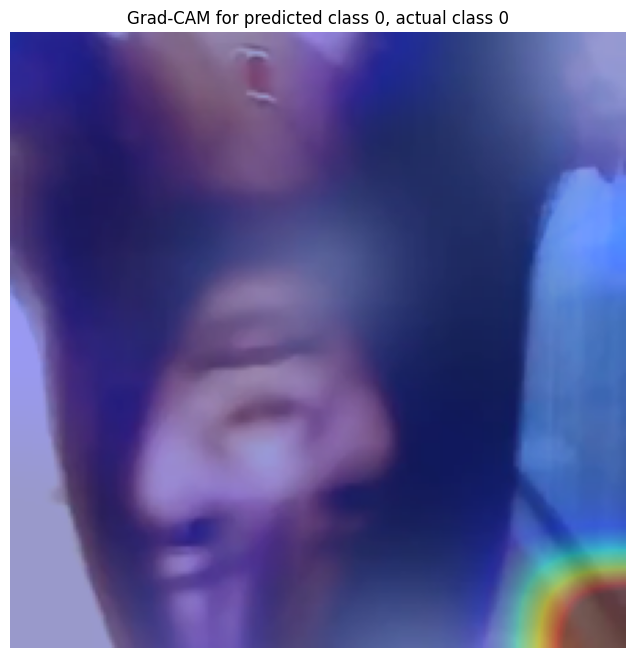

In [30]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
# Set CNN layers to evaluation mode
model.cnn.eval()

# Grad-CAM generation code
cam_extractor = GradCAM(model.cnn.features, target_layer='13')  # Adjust based on MobileNetV3 architecture

# Sample input - A batch of one sample with a sequence of 3 RGB images (e.g., 224x224 size)
# sample_input = torch.randn(1, 3, 3, 224, 224).to(device)  # Replace with actual input

# Use the actual data from the test loader
test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/test', transform=transform, num_frames=3)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True)

for inputs, labels in test_loader:
    sample_input = inputs.to(device)
    print(sample_input.shape)
    labels = labels.to(device)
    break  # Just use one batch for demonstration

# Forward pass
output = model(sample_input)

# Get predicted class
predicted_class = output.argmax(dim=-1).item()

# Extract Grad-CAM
activation_map = cam_extractor(predicted_class, output)[0]  # Visualize the first sequence element

# Visualize the Grad-CAM
input_image = sample_input[0, 0, :, :, :]  # Select the first image in the sequence
input_image = input_image.cpu()

# Convert the activation map and the input image to PIL for visualization
activation_map = activation_map.squeeze().cpu().numpy()
input_image_pil = to_pil_image(input_image)

# Overlay Grad-CAM on the original image
result = overlay_mask(input_image_pil, to_pil_image(activation_map, mode='F'), alpha=0.6)

# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.title(f'Grad-CAM for predicted class {predicted_class}, actual class {labels[0].item()}')
plt.axis('off')
plt.show()
